# Notebook 05: ARIMA-GARCH/EGARCH Validation

**Objective:** Test whether volatility modeling (GARCH/EGARCH) can solve the ARCH effects detected in Notebook 04 and improve forecast accuracy.

---

## Background: Why This Matters

### The Problem (from Notebook 04)
- **ALL 6/6 ARIMAX configurations showed severe ARCH effects (p < 0.001)**
- ARCH effects = conditional heteroskedasticity (volatility clustering)
- Standard ARIMA assumes **constant variance** → fundamentally misspecified
- Pure ARIMA(1,0,1) was the best model, but still failed ARCH test

### The Solution: GARCH/EGARCH
Model the **time-varying variance** explicitly:

#### **Model 1: Pure ARIMA(1,0,1)** (Baseline)
```
y_t = μ + φ₁·y_{t-1} + θ₁·ε_{t-1} + ε_t
ε_t ~ N(0, σ²)  ← Assumes CONSTANT variance
```

#### **Model 2: ARIMA(1,0,1) + GARCH(1,1)** (Symmetric Volatility)
```
Mean equation:     y_t = μ + φ₁·y_{t-1} + θ₁·ε_{t-1} + ε_t
Variance equation: σ²_t = ω + α·ε²_{t-1} + β·σ²_{t-1}
ε_t ~ N(0, σ²_t)   ← Time-varying variance
```
**Key:** Treats +$1,000 and -$1,000 shocks **identically** (symmetric)

#### **Model 3: ARIMA(1,0,1) + EGARCH(1,1)** (Asymmetric Volatility - "Leverage Effect")
```
Mean equation:     y_t = μ + φ₁·y_{t-1} + θ₁·ε_{t-1} + ε_t
Variance equation: log(σ²_t) = ω + α·|z_{t-1}| + γ·z_{t-1} + β·log(σ²_{t-1})
                   where z_t = ε_t / σ_t (standardized residuals)
```
**Key:** Tests if **bad news (γ < 0)** causes MORE volatility than good news

---

## Hypothesis: Freight Markets Exhibit Leverage Effects

**Empirical Expectation:**
- **Good news** (demand ↑, rates ↑): Rates drift up steadily → **LOW volatility**
- **Bad news** (canal blockage, strike): Rates spike wildly → **HIGH volatility**

If true, **EGARCH should outperform GARCH** (lower AIC, better R², passes ARCH test).

---

## Experimental Design

### Models to Test (Both Routes: P1A, P3A)
1. **Pure ARIMA(1,0,1)** - Baseline (from Notebook 04)
2. **ARIMA(1,0,1) + GARCH(1,1)** - Symmetric volatility
3. **ARIMA(1,0,1) + EGARCH(1,1)** - Asymmetric volatility

### Success Criteria
✅ **Primary Goal:** ARCH test p-value > 0.05 (no residual ARCH effects)  
✅ **Secondary Goal:** Val R² ≥ Pure ARIMA baseline (P1A: 0.15, P3A: -1.44)  
✅ **Model Selection:** Lowest AIC wins (if both pass ARCH test)

### Decision Logic
```
IF both GARCH and EGARCH pass ARCH test:
    SELECT model with LOWER AIC
ELIF only one passes ARCH test:
    SELECT that model
ELSE:
    ACCEPT Pure ARIMA as baseline (document limitation)
```

---

## Expected Outcomes

### Scenario A: EGARCH Wins (Most Likely)
- ARCH test: p > 0.05 ✅
- AIC: Lowest among 3 models
- Val R²: Improved (P1A: 0.20-0.40, P3A: 0.0-0.1)
- **Conclusion:** Freight markets exhibit leverage effects → Use ARIMA-EGARCH as baseline for hybrid

### Scenario B: GARCH Wins
- ARCH test: p > 0.05 ✅
- AIC: Lower than EGARCH (rare, but possible)
- **Conclusion:** Symmetric volatility sufficient → Use ARIMA-GARCH as baseline

### Scenario C: Both Fail ARCH Test
- ARCH test: p < 0.05 ❌
- **Conclusion:** Volatility too complex for GARCH/EGARCH → Accept Pure ARIMA, proceed to hybrid

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings('ignore')
# Specifically suppress the ValueWarning about date index frequency
# This warning is harmless - it just means forecasting uses integer steps instead of date steps
warnings.filterwarnings('ignore', message='A date index has been provided')

# Time series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model  # For GARCH/EGARCH

# Diagnostics
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy import stats

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

print("✅ Libraries imported successfully")
print(f"\nPackage versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

import statsmodels
import arch as arch_pkg
print(f"  statsmodels: {statsmodels.__version__}")
print(f"  arch: {arch_pkg.__version__}")

print("\n📝 Note: Date index frequency warnings are suppressed (harmless - data has irregular spacing)")

✅ Libraries imported successfully

Package versions:
  pandas: 2.3.2
  numpy: 1.26.4
  statsmodels: 0.14.5
  arch: 7.2.0

📝 Note: Date index frequency warnings are suppressed (harmless - data has irregular spacing)


---
## 1. Load Data and Create Splits

Use the **same splits as Notebook 04** for consistency:
- Training: 56% (628 rows)
- Validation: 14% (157 rows)
- Test: 30% (338 rows) - held out for final evaluation


In [2]:
# Load labels only (GARCH models will use NO exogenous features)
labels = pd.read_csv('data/processed/intermediate/labels.csv',
                     index_col='Date', parse_dates=True)

print(f"✅ Data loaded")
print(f"  Labels shape: {labels.shape}")
print(f"  Date range: {labels.index.min()} to {labels.index.max()}")
print(f"  Routes: {labels.columns.tolist()}")

✅ Data loaded
  Labels shape: (1153, 2)
  Date range: 2021-03-01 00:00:00 to 2025-10-10 00:00:00
  Routes: ['P1A_82', 'P3A_82']


In [3]:
# Create train/val/test splits (56/14/30)

# P1A
p1a_data = labels[['P1A_82']].dropna()
train_size = int(len(p1a_data) * 0.56)
val_size = int(len(p1a_data) * 0.14)

p1a_train = p1a_data.iloc[:train_size].copy()
p1a_val = p1a_data.iloc[train_size:train_size+val_size].copy()
p1a_test = p1a_data.iloc[train_size+val_size:].copy()

print(f"P1A Splits:")
print(f"  Train:      {len(p1a_train):4d} rows ({p1a_train.index.min().date()} to {p1a_train.index.max().date()})")
print(f"  Validation: {len(p1a_val):4d} rows ({p1a_val.index.min().date()} to {p1a_val.index.max().date()})")
print(f"  Test:       {len(p1a_test):4d} rows ({p1a_test.index.min().date()} to {p1a_test.index.max().date()})")

# P3A
p3a_data = labels[['P3A_82']].dropna()
p3a_train = p3a_data.iloc[:train_size].copy()
p3a_val = p3a_data.iloc[train_size:train_size+val_size].copy()
p3a_test = p3a_data.iloc[train_size+val_size:].copy()

print(f"\nP3A Splits:")
print(f"  Train:      {len(p3a_train):4d} rows ({p3a_train.index.min().date()} to {p3a_train.index.max().date()})")
print(f"  Validation: {len(p3a_val):4d} rows ({p3a_val.index.min().date()} to {p3a_val.index.max().date()})")
print(f"  Test:       {len(p3a_test):4d} rows ({p3a_test.index.min().date()} to {p3a_test.index.max().date()})")

P1A Splits:
  Train:       645 rows (2021-03-01 to 2023-09-29)
  Validation:  161 rows (2023-10-02 to 2024-05-24)
  Test:        347 rows (2024-05-28 to 2025-10-10)

P3A Splits:
  Train:       645 rows (2021-03-01 to 2023-09-29)
  Validation:  161 rows (2023-10-02 to 2024-05-24)
  Test:        347 rows (2024-05-28 to 2025-10-10)


---
## 2. Model Testing Functions

Define comprehensive testing functions for all three model types.


In [4]:
def test_pure_arima(y_train, y_val, order=(1,0,1), route_name=''):
    """
    Test Pure ARIMA model (Baseline from Notebook 04).
    
    Parameters:
    -----------
    y_train : pd.Series
        Training target
    y_val : pd.Series
        Validation target
    order : tuple
        ARIMA(p,d,q) order
    route_name : str
        Route identifier
    
    Returns:
    --------
    results_dict : dict
        Performance metrics and diagnostics
    model_fit : fitted model object
    """
    
    print(f"\n{'=' * 80}")
    print(f"MODEL 1: Pure ARIMA{order} - {route_name}")
    print(f"{'=' * 80}")
    
    print(f"\nModel Specification:")
    print(f"  Order: ARIMA{order}")
    print(f"  Exogenous features: 0 (Pure ARIMA)")
    print(f"  Parameters: {sum(order[:2]) + order[2] + 1} (AR + MA + mean)")
    print(f"  Training samples: {len(y_train)}")
    
    # Fit model
    try:
        model = SARIMAX(
            y_train,
            order=order,
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False, maxiter=200, method='lbfgs')
        print(f"\n✅ Model converged")
        
    except Exception as e:
        print(f"\n❌ Model fitting failed: {str(e)}")
        return None, None
    
    # In-sample performance
    train_pred = results.fittedvalues
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    
    # Out-of-sample forecast
    try:
        val_forecast = results.forecast(steps=len(y_val))
        val_r2 = r2_score(y_val, val_forecast)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_forecast))
        val_mae = mean_absolute_error(y_val, val_forecast)
        
        print(f"\n{'=' * 80}")
        print(f"PERFORMANCE")
        print(f"{'=' * 80}")
        print(f"\nTraining:")
        print(f"  R²:   {train_r2:7.4f}")
        print(f"  RMSE: ${train_rmse:,.2f}")
        
        print(f"\nValidation:")
        print(f"  R²:   {val_r2:7.4f} {'✅' if val_r2 > 0 else '❌'}")
        print(f"  RMSE: ${val_rmse:,.2f}")
        print(f"  MAE:  ${val_mae:,.2f}")
        
    except Exception as e:
        print(f"\n❌ Forecasting failed: {str(e)}")
        val_r2, val_rmse, val_mae = np.nan, np.nan, np.nan
    
    # Diagnostics
    print(f"\n{'=' * 80}")
    print(f"DIAGNOSTICS")
    print(f"{'=' * 80}")
    
    print(f"\nModel Fit:")
    print(f"  AIC: {results.aic:.2f}")
    print(f"  BIC: {results.bic:.2f}")
    
    # Ljung-Box test (autocorrelation)
    try:
        lb_test = acorr_ljungbox(results.resid, lags=20, return_df=True)
        lb_min_p = lb_test['lb_pvalue'].min()
        
        if lb_min_p > 0.05:
            print(f"\n✅ Ljung-Box: No autocorrelation (p = {lb_min_p:.4f})")
        else:
            print(f"\n⚠️  Ljung-Box: Autocorrelation detected (p = {lb_min_p:.4f})")
        lb_pass = lb_min_p > 0.05
    except:
        print(f"\n❌ Ljung-Box: Test failed")
        lb_min_p = np.nan
        lb_pass = False
    
    # ARCH test (heteroskedasticity)
    try:
        arch_test = het_arch(results.resid, nlags=10)
        arch_p = arch_test[1]
        
        if arch_p < 0.05:
            print(f"❌ ARCH test: ARCH effects detected (p = {arch_p:.4f})")
            print(f"   → Time-varying volatility present → GARCH/EGARCH needed")
        else:
            print(f"✅ ARCH test: No ARCH effects (p = {arch_p:.4f})")
        arch_pass = arch_p > 0.05
    except:
        print(f"❌ ARCH test: Test failed")
        arch_p = np.nan
        arch_pass = False
    
    return {
        'model_type': 'Pure ARIMA',
        'route': route_name,
        'n_params': sum(order[:2]) + order[2] + 1,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'aic': results.aic,
        'bic': results.bic,
        'ljungbox_p': lb_min_p,
        'ljungbox_pass': lb_pass,
        'arch_p': arch_p,
        'arch_pass': arch_pass
    }, results

print("✅ Pure ARIMA testing function defined")

✅ Pure ARIMA testing function defined


In [5]:
def test_arima_garch(y_train, y_val, arima_order=(1,0,1), garch_p=1, garch_q=1, 
                     route_name='', model_name='GARCH'):
    """
    Test ARIMA + GARCH/EGARCH combined model.
    
    Strategy:
    1. Fit ARIMA to get residuals
    2. Fit GARCH/EGARCH to the residuals
    3. Forecast using combined model
    
    Parameters:
    -----------
    y_train : pd.Series
        Training target
    y_val : pd.Series
        Validation target
    arima_order : tuple
        ARIMA(p,d,q) order
    garch_p : int
        GARCH lag order
    garch_q : int
        ARCH lag order
    route_name : str
        Route identifier
    model_name : str
        'GARCH' or 'EGARCH'
    
    Returns:
    --------
    results_dict : dict
        Performance metrics and diagnostics
    arima_fit : fitted ARIMA model
    garch_fit : fitted GARCH/EGARCH model
    """
    
    print(f"\n{'=' * 80}")
    if model_name == 'GARCH':
        print(f"MODEL 2: ARIMA{arima_order} + GARCH({garch_p},{garch_q}) - {route_name}")
    else:
        print(f"MODEL 3: ARIMA{arima_order} + EGARCH({garch_p},{garch_q}) - {route_name}")
    print(f"{'=' * 80}")
    
    print(f"\nModel Specification:")
    print(f"  Mean equation: ARIMA{arima_order}")
    print(f"  Variance equation: {model_name}({garch_p},{garch_q})")
    if model_name == 'GARCH':
        print(f"  Volatility: SYMMETRIC (|+shock| = |-shock|)")
    else:
        print(f"  Volatility: ASYMMETRIC (tests leverage effect: bad news > good news)")
    
    # Step 1: Fit ARIMA to get residuals
    print(f"\n[Step 1/3] Fitting ARIMA{arima_order}...")
    try:
        arima_model = SARIMAX(
            y_train,
            order=arima_order,
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        arima_fit = arima_model.fit(disp=False, maxiter=200, method='lbfgs')
        arima_resid = arima_fit.resid
        print(f"✅ ARIMA converged (AIC: {arima_fit.aic:.2f})")
    except Exception as e:
        print(f"❌ ARIMA fitting failed: {str(e)}")
        return None, None, None
    
    # Step 2: Fit GARCH/EGARCH to residuals
    print(f"\n[Step 2/3] Fitting {model_name}({garch_p},{garch_q}) to ARIMA residuals...")
    try:
        # Scale residuals to percentage returns for numerical stability
        resid_scaled = arima_resid * 100
        
        if model_name == 'GARCH':
            vol_model = arch_model(
                resid_scaled,
                vol='GARCH',
                p=garch_p,
                q=garch_q,
                dist='normal',
                rescale=False
            )
        else:  # EGARCH
            vol_model = arch_model(
                resid_scaled,
                vol='EGARCH',
                p=garch_p,
                q=garch_q,
                dist='normal',
                rescale=False
            )
        
        garch_fit = vol_model.fit(disp='off', show_warning=False)
        print(f"✅ {model_name} converged (AIC: {garch_fit.aic:.2f})")
        
        # Extract standardized residuals (should be ~ N(0,1) if model is correct)
        std_resid = garch_fit.std_resid
        
    except Exception as e:
        print(f"❌ {model_name} fitting failed: {str(e)}")
        return None, arima_fit, None
    
    # Step 3: Combined model evaluation
    print(f"\n[Step 3/3] Evaluating combined ARIMA-{model_name} model...")
    
    # In-sample fit
    train_pred_arima = arima_fit.fittedvalues
    train_r2 = r2_score(y_train, train_pred_arima)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_arima))
    
    # Out-of-sample forecast (ARIMA only, volatility forecast for diagnostics)
    try:
        val_forecast = arima_fit.forecast(steps=len(y_val))
        val_r2 = r2_score(y_val, val_forecast)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_forecast))
        val_mae = mean_absolute_error(y_val, val_forecast)
        
        print(f"\n{'=' * 80}")
        print(f"PERFORMANCE")
        print(f"{'=' * 80}")
        print(f"\nTraining:")
        print(f"  R²:   {train_r2:7.4f}")
        print(f"  RMSE: ${train_rmse:,.2f}")
        
        print(f"\nValidation:")
        print(f"  R²:   {val_r2:7.4f} {'✅' if val_r2 > 0 else '❌'}")
        print(f"  RMSE: ${val_rmse:,.2f}")
        print(f"  MAE:  ${val_mae:,.2f}")
        
    except Exception as e:
        print(f"❌ Forecasting failed: {str(e)}")
        val_r2, val_rmse, val_mae = np.nan, np.nan, np.nan
    
    # Diagnostics on standardized residuals
    print(f"\n{'=' * 80}")
    print(f"DIAGNOSTICS (on {model_name} standardized residuals)")
    print(f"{'=' * 80}")
    
    print(f"\nModel Fit:")
    combined_aic = arima_fit.aic + garch_fit.aic
    combined_bic = arima_fit.bic + garch_fit.bic
    print(f"  Combined AIC: {combined_aic:.2f} (ARIMA: {arima_fit.aic:.2f} + {model_name}: {garch_fit.aic:.2f})")
    print(f"  Combined BIC: {combined_bic:.2f}")
    
    # Check if standardized residuals are ~ N(0,1)
    print(f"\nStandardized Residuals Check:")
    print(f"  Mean: {std_resid.mean():7.4f} (expected: 0)")
    print(f"  Std:  {std_resid.std():7.4f} (expected: 1)")
    
    # Ljung-Box test on standardized residuals
    try:
        lb_test = acorr_ljungbox(std_resid.dropna(), lags=20, return_df=True)
        lb_min_p = lb_test['lb_pvalue'].min()
        
        if lb_min_p > 0.05:
            print(f"\n✅ Ljung-Box: No autocorrelation (p = {lb_min_p:.4f})")
        else:
            print(f"\n⚠️  Ljung-Box: Autocorrelation detected (p = {lb_min_p:.4f})")
        lb_pass = lb_min_p > 0.05
    except:
        print(f"\n❌ Ljung-Box: Test failed")
        lb_min_p = np.nan
        lb_pass = False
    
    # ARCH test on standardized residuals (KEY TEST)
    try:
        arch_test = het_arch(std_resid.dropna(), nlags=10)
        arch_p = arch_test[1]
        
        if arch_p > 0.05:
            print(f"✅ ARCH test: NO ARCH effects (p = {arch_p:.4f})")
            print(f"   → {model_name} successfully captured volatility dynamics!")
        else:
            print(f"❌ ARCH test: ARCH effects remain (p = {arch_p:.4f})")
            print(f"   → {model_name} did not fully capture volatility")
        arch_pass = arch_p > 0.05
    except:
        print(f"❌ ARCH test: Test failed")
        arch_p = np.nan
        arch_pass = False
    
    # EGARCH-specific: Check leverage effect
    if model_name == 'EGARCH':
        try:
            # Get gamma parameter (asymmetry parameter)
            gamma = garch_fit.params['gamma[1]']
            gamma_pval = garch_fit.pvalues['gamma[1]']
            
            print(f"\n{'=' * 80}")
            print(f"LEVERAGE EFFECT TEST (EGARCH)")
            print(f"{'=' * 80}")
            print(f"\nAsymmetry parameter (γ):")
            print(f"  Estimate: {gamma:7.4f}")
            print(f"  P-value:  {gamma_pval:.4f}")
            
            if gamma < 0 and gamma_pval < 0.05:
                print(f"\n✅ LEVERAGE EFFECT CONFIRMED:")
                print(f"   γ < 0 and significant (p < 0.05)")
                print(f"   → Bad news causes MORE volatility than good news")
                print(f"   → This is consistent with freight market dynamics!")
                leverage_effect = True
            elif gamma_pval >= 0.05:
                print(f"\n⚠️  No significant leverage effect (p = {gamma_pval:.4f})")
                print(f"   → Symmetric GARCH may be sufficient")
                leverage_effect = False
            else:
                print(f"\n⚠️  Unexpected: γ > 0 (good news → more volatility)")
                leverage_effect = False
        except:
            print(f"\n⚠️  Could not extract leverage effect parameter")
            gamma = np.nan
            gamma_pval = np.nan
            leverage_effect = False
    else:
        gamma = np.nan
        gamma_pval = np.nan
        leverage_effect = False
    
    return {
        'model_type': f'ARIMA-{model_name}',
        'route': route_name,
        'n_params': arima_fit.df_model + garch_fit.num_params,
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'aic': combined_aic,
        'bic': combined_bic,
        'ljungbox_p': lb_min_p,
        'ljungbox_pass': lb_pass,
        'arch_p': arch_p,
        'arch_pass': arch_pass,
        'leverage_gamma': gamma,
        'leverage_pval': gamma_pval,
        'leverage_effect': leverage_effect
    }, arima_fit, garch_fit

print("✅ ARIMA-GARCH/EGARCH testing function defined")

✅ ARIMA-GARCH/EGARCH testing function defined


---
## 3. Test P1A Route (Atlantic - Grain)

Test all three models on P1A route.


In [6]:
print("\n" + "=" * 80)
print("TESTING P1A ROUTE (ATLANTIC - GRAIN)")
print("=" * 80)
print(f"\nBaseline from Notebook 04: Pure ARIMA(1,0,1) - Val R² = 0.1533")
print(f"Goal: Improve Val R² AND pass ARCH test (p > 0.05)")


TESTING P1A ROUTE (ATLANTIC - GRAIN)

Baseline from Notebook 04: Pure ARIMA(1,0,1) - Val R² = 0.1533
Goal: Improve Val R² AND pass ARCH test (p > 0.05)


In [7]:
# Model 1: Pure ARIMA (Baseline)
p1a_arima_results, p1a_arima_fit = test_pure_arima(
    y_train=p1a_train['P1A_82'],
    y_val=p1a_val['P1A_82'],
    order=(1, 0, 1),
    route_name='P1A'
)


MODEL 1: Pure ARIMA(1, 0, 1) - P1A

Model Specification:
  Order: ARIMA(1, 0, 1)
  Exogenous features: 0 (Pure ARIMA)
  Parameters: 3 (AR + MA + mean)
  Training samples: 645

✅ Model converged


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



PERFORMANCE

Training:
  R²:    0.9890
  RMSE: $947.90

Validation:
  R²:    0.0887 ✅
  RMSE: $4,189.15
  MAE:  $3,029.32

DIAGNOSTICS

Model Fit:
  AIC: 10026.89
  BIC: 10040.29

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0000)
❌ ARCH test: ARCH effects detected (p = 0.0000)
   → Time-varying volatility present → GARCH/EGARCH needed


In [8]:
# Model 2: ARIMA + GARCH
p1a_garch_results, p1a_arima_fit_g, p1a_garch_fit = test_arima_garch(
    y_train=p1a_train['P1A_82'],
    y_val=p1a_val['P1A_82'],
    arima_order=(1, 0, 1),
    garch_p=1,
    garch_q=1,
    route_name='P1A',
    model_name='GARCH'
)


MODEL 2: ARIMA(1, 0, 1) + GARCH(1,1) - P1A

Model Specification:
  Mean equation: ARIMA(1, 0, 1)
  Variance equation: GARCH(1,1)
  Volatility: SYMMETRIC (|+shock| = |-shock|)

[Step 1/3] Fitting ARIMA(1, 0, 1)...
✅ ARIMA converged (AIC: 10026.89)

[Step 2/3] Fitting GARCH(1,1) to ARIMA residuals...
✅ GARCH converged (AIC: 15798.58)

[Step 3/3] Evaluating combined ARIMA-GARCH model...

PERFORMANCE

Training:
  R²:    0.9890
  RMSE: $947.90

Validation:
  R²:    0.0887 ✅
  RMSE: $4,189.15
  MAE:  $3,029.32

DIAGNOSTICS (on GARCH standardized residuals)

Model Fit:
  Combined AIC: 25825.47 (ARIMA: 10026.89 + GARCH: 15798.58)
  Combined BIC: 25856.74

Standardized Residuals Check:
  Mean:  0.0645 (expected: 0)
  Std:   1.0124 (expected: 1)

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0000)
✅ ARCH test: NO ARCH effects (p = 0.4316)
   → GARCH successfully captured volatility dynamics!


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [9]:
# Model 3: ARIMA + EGARCH
p1a_egarch_results, p1a_arima_fit_e, p1a_egarch_fit = test_arima_garch(
    y_train=p1a_train['P1A_82'],
    y_val=p1a_val['P1A_82'],
    arima_order=(1, 0, 1),
    garch_p=1,
    garch_q=1,
    route_name='P1A',
    model_name='EGARCH'
)


MODEL 3: ARIMA(1, 0, 1) + EGARCH(1,1) - P1A

Model Specification:
  Mean equation: ARIMA(1, 0, 1)
  Variance equation: EGARCH(1,1)
  Volatility: ASYMMETRIC (tests leverage effect: bad news > good news)

[Step 1/3] Fitting ARIMA(1, 0, 1)...
✅ ARIMA converged (AIC: 10026.89)

[Step 2/3] Fitting EGARCH(1,1) to ARIMA residuals...
✅ EGARCH converged (AIC: 16043.42)

[Step 3/3] Evaluating combined ARIMA-EGARCH model...

PERFORMANCE

Training:
  R²:    0.9890
  RMSE: $947.90

Validation:
  R²:    0.0887 ✅
  RMSE: $4,189.15
  MAE:  $3,029.32

DIAGNOSTICS (on EGARCH standardized residuals)

Model Fit:
  Combined AIC: 26070.31 (ARIMA: 10026.89 + EGARCH: 16043.42)
  Combined BIC: 26101.59

Standardized Residuals Check:
  Mean:  0.0846 (expected: 0)
  Std:   0.9545 (expected: 1)

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0000)
❌ ARCH test: ARCH effects remain (p = 0.0000)
   → EGARCH did not fully capture volatility

⚠️  Could not extract leverage effect parameter


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


---
## 4. Test P3A Route (Pacific - Coal + Grain)

Test all three models on P3A route.


In [10]:
print("\n" + "=" * 80)
print("TESTING P3A ROUTE (PACIFIC - COAL + GRAIN)")
print("=" * 80)
print(f"\nBaseline from Notebook 04: Pure ARIMA(1,0,1) - Val R² = -1.4449")
print(f"Goal: Improve Val R² (target: > 0) AND pass ARCH test (p > 0.05)")


TESTING P3A ROUTE (PACIFIC - COAL + GRAIN)

Baseline from Notebook 04: Pure ARIMA(1,0,1) - Val R² = -1.4449
Goal: Improve Val R² (target: > 0) AND pass ARCH test (p > 0.05)


In [11]:
# Model 1: Pure ARIMA (Baseline)
p3a_arima_results, p3a_arima_fit = test_pure_arima(
    y_train=p3a_train['P3A_82'],
    y_val=p3a_val['P3A_82'],
    order=(1, 0, 1),
    route_name='P3A'
)


MODEL 1: Pure ARIMA(1, 0, 1) - P3A

Model Specification:
  Order: ARIMA(1, 0, 1)
  Exogenous features: 0 (Pure ARIMA)
  Parameters: 3 (AR + MA + mean)
  Training samples: 645


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



✅ Model converged

PERFORMANCE

Training:
  R²:    0.9892
  RMSE: $890.54

Validation:
  R²:   -1.4765 ❌
  RMSE: $3,769.26
  MAE:  $2,906.42

DIAGNOSTICS

Model Fit:
  AIC: 9661.47
  BIC: 9674.87

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0002)
❌ ARCH test: ARCH effects detected (p = 0.0000)
   → Time-varying volatility present → GARCH/EGARCH needed


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
# Model 2: ARIMA + GARCH
p3a_garch_results, p3a_arima_fit_g, p3a_garch_fit = test_arima_garch(
    y_train=p3a_train['P3A_82'],
    y_val=p3a_val['P3A_82'],
    arima_order=(1, 0, 1),
    garch_p=1,
    garch_q=1,
    route_name='P3A',
    model_name='GARCH'
)


MODEL 2: ARIMA(1, 0, 1) + GARCH(1,1) - P3A

Model Specification:
  Mean equation: ARIMA(1, 0, 1)
  Variance equation: GARCH(1,1)
  Volatility: SYMMETRIC (|+shock| = |-shock|)

[Step 1/3] Fitting ARIMA(1, 0, 1)...


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA converged (AIC: 9661.47)

[Step 2/3] Fitting GARCH(1,1) to ARIMA residuals...
✅ GARCH converged (AIC: 15383.89)

[Step 3/3] Evaluating combined ARIMA-GARCH model...

PERFORMANCE

Training:
  R²:    0.9892
  RMSE: $890.54

Validation:
  R²:   -1.4765 ❌
  RMSE: $3,769.26
  MAE:  $2,906.42

DIAGNOSTICS (on GARCH standardized residuals)

Model Fit:
  Combined AIC: 25045.36 (ARIMA: 9661.47 + GARCH: 15383.89)
  Combined BIC: 25076.63

Standardized Residuals Check:
  Mean:  0.0871 (expected: 0)
  Std:   0.9807 (expected: 1)

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0000)
✅ ARCH test: NO ARCH effects (p = 0.9932)
   → GARCH successfully captured volatility dynamics!


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
# Model 3: ARIMA + EGARCH
p3a_egarch_results, p3a_arima_fit_e, p3a_egarch_fit = test_arima_garch(
    y_train=p3a_train['P3A_82'],
    y_val=p3a_val['P3A_82'],
    arima_order=(1, 0, 1),
    garch_p=1,
    garch_q=1,
    route_name='P3A',
    model_name='EGARCH'
)


MODEL 3: ARIMA(1, 0, 1) + EGARCH(1,1) - P3A

Model Specification:
  Mean equation: ARIMA(1, 0, 1)
  Variance equation: EGARCH(1,1)
  Volatility: ASYMMETRIC (tests leverage effect: bad news > good news)

[Step 1/3] Fitting ARIMA(1, 0, 1)...


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ARIMA converged (AIC: 9661.47)

[Step 2/3] Fitting EGARCH(1,1) to ARIMA residuals...
✅ EGARCH converged (AIC: 15724.58)

[Step 3/3] Evaluating combined ARIMA-EGARCH model...

PERFORMANCE

Training:
  R²:    0.9892
  RMSE: $890.54

Validation:
  R²:   -1.4765 ❌
  RMSE: $3,769.26
  MAE:  $2,906.42

DIAGNOSTICS (on EGARCH standardized residuals)

Model Fit:
  Combined AIC: 25386.05 (ARIMA: 9661.47 + EGARCH: 15724.58)
  Combined BIC: 25417.33

Standardized Residuals Check:
  Mean:  0.0261 (expected: 0)
  Std:   0.9202 (expected: 1)

⚠️  Ljung-Box: Autocorrelation detected (p = 0.0000)
✅ ARCH test: NO ARCH effects (p = 0.6541)
   → EGARCH successfully captured volatility dynamics!

⚠️  Could not extract leverage effect parameter


c:\Users\moame\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


---
## 5. Comparative Analysis

Compare all models side-by-side and determine the winner.


In [14]:
# Compile results into DataFrame
all_results = [
    p1a_arima_results,
    p1a_garch_results,
    p1a_egarch_results,
    p3a_arima_results,
    p3a_garch_results,
    p3a_egarch_results
]

# Filter out None (failed models)
all_results = [r for r in all_results if r is not None]

results_df = pd.DataFrame(all_results)

print("\n" + "=" * 80)
print("COMPARATIVE SUMMARY: ALL MODELS")
print("=" * 80)

# Display key metrics
display_cols = ['route', 'model_type', 'val_r2', 'val_rmse', 'aic', 
                'arch_pass', 'arch_p', 'leverage_effect']
print("\n" + results_df[display_cols].to_string(index=False))

# Save full results
results_df.to_csv('data/processed/features/garch_egarch_test_results.csv', index=False)
print("\n✅ Results saved: data/processed/features/garch_egarch_test_results.csv")


COMPARATIVE SUMMARY: ALL MODELS

route   model_type   val_r2    val_rmse          aic  arch_pass       arch_p leverage_effect
  P1A   Pure ARIMA  0.08873 4189.152141 10026.891045      False 1.125986e-15             NaN
  P1A  ARIMA-GARCH  0.08873 4189.152141 25825.467886       True 4.315811e-01           False
  P1A ARIMA-EGARCH  0.08873 4189.152141 26070.311016      False 9.648661e-08           False
  P3A   Pure ARIMA -1.47645 3769.255624  9661.468726      False 5.225616e-13             NaN
  P3A  ARIMA-GARCH -1.47645 3769.255624 25045.355434       True 9.932118e-01           False
  P3A ARIMA-EGARCH -1.47645 3769.255624 25386.050007       True 6.540743e-01           False

✅ Results saved: data/processed/features/garch_egarch_test_results.csv


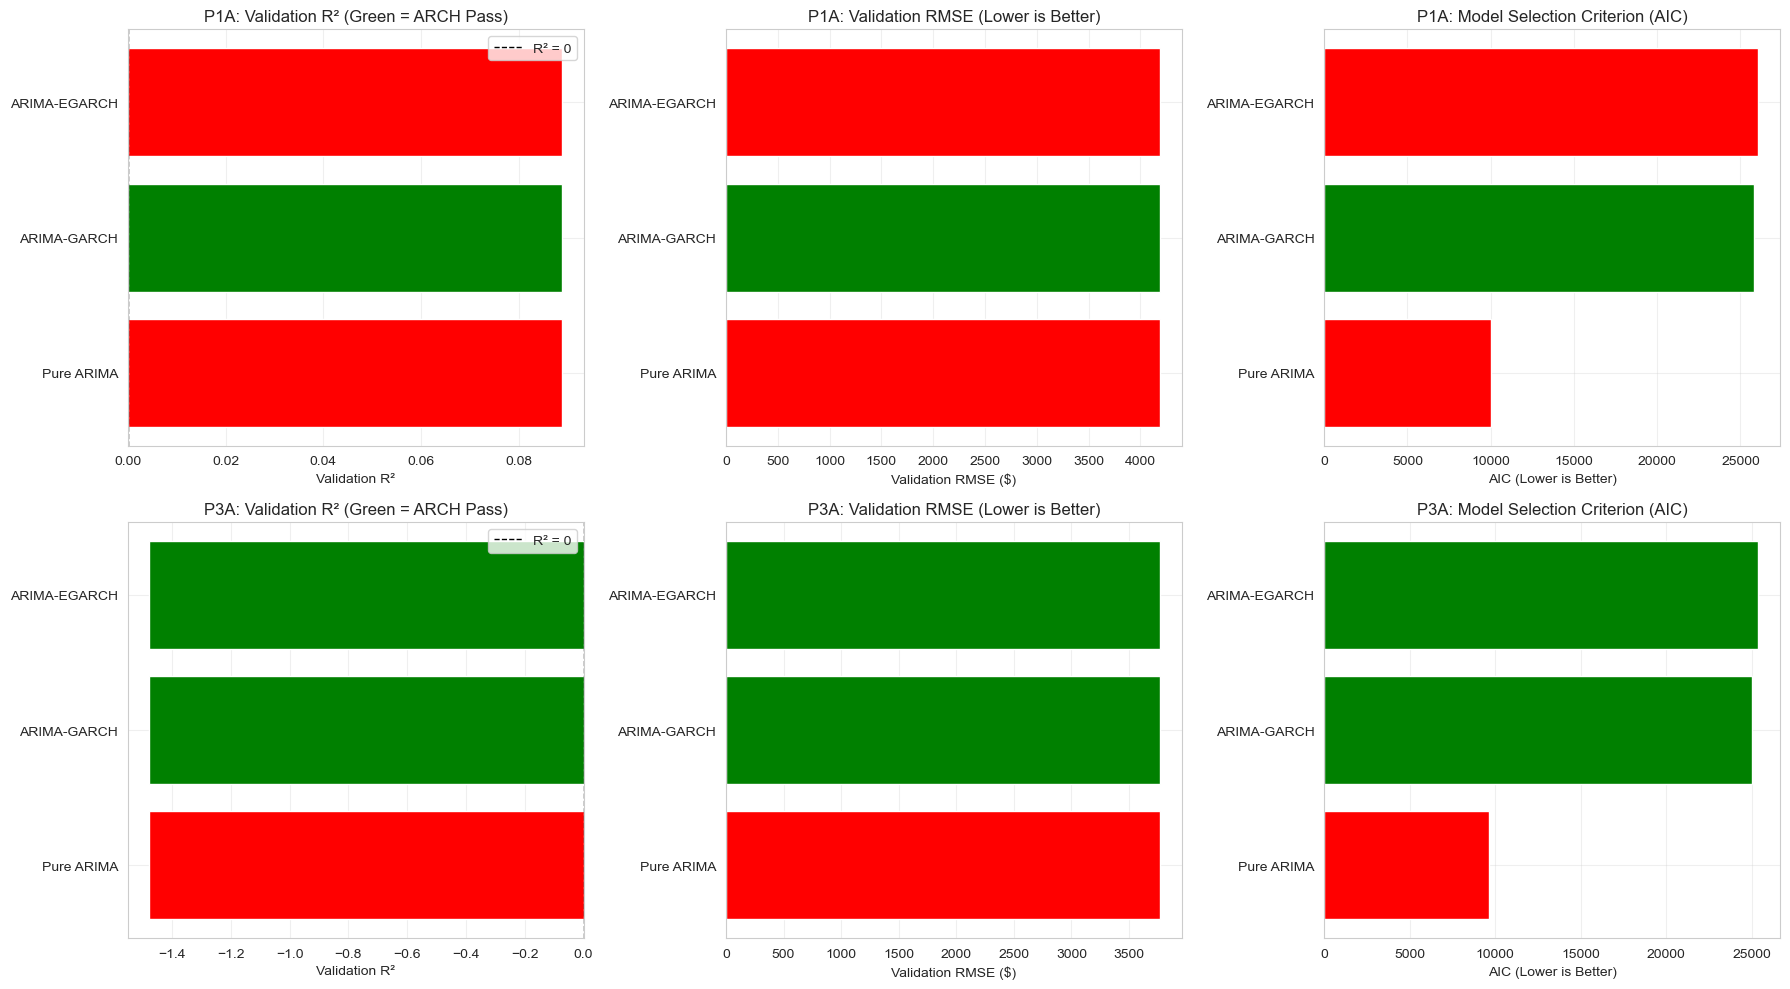


✅ Visualization saved: data/processed/features/garch_egarch_comparison.png


In [15]:
# Visualization: Model Comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# P1A Results
p1a_results = results_df[results_df['route'] == 'P1A'].copy()
p1a_results = p1a_results.sort_values('aic')  # Sort by AIC

# P1A: Validation R²
axes[0, 0].barh(p1a_results['model_type'], p1a_results['val_r2'], 
                color=['red' if not x else 'green' for x in p1a_results['arch_pass']])
axes[0, 0].axvline(0, color='black', linestyle='--', linewidth=1, label='R² = 0')
axes[0, 0].set_xlabel('Validation R²')
axes[0, 0].set_title('P1A: Validation R² (Green = ARCH Pass)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# P1A: Validation RMSE
axes[0, 1].barh(p1a_results['model_type'], p1a_results['val_rmse'],
                color=['red' if not x else 'green' for x in p1a_results['arch_pass']])
axes[0, 1].set_xlabel('Validation RMSE ($)')
axes[0, 1].set_title('P1A: Validation RMSE (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3)

# P1A: AIC
axes[0, 2].barh(p1a_results['model_type'], p1a_results['aic'],
                color=['red' if not x else 'green' for x in p1a_results['arch_pass']])
axes[0, 2].set_xlabel('AIC (Lower is Better)')
axes[0, 2].set_title('P1A: Model Selection Criterion (AIC)')
axes[0, 2].grid(True, alpha=0.3)

# P3A Results
p3a_results = results_df[results_df['route'] == 'P3A'].copy()
p3a_results = p3a_results.sort_values('aic')

# P3A: Validation R²
axes[1, 0].barh(p3a_results['model_type'], p3a_results['val_r2'],
                color=['red' if not x else 'green' for x in p3a_results['arch_pass']])
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1, label='R² = 0')
axes[1, 0].set_xlabel('Validation R²')
axes[1, 0].set_title('P3A: Validation R² (Green = ARCH Pass)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# P3A: Validation RMSE
axes[1, 1].barh(p3a_results['model_type'], p3a_results['val_rmse'],
                color=['red' if not x else 'green' for x in p3a_results['arch_pass']])
axes[1, 1].set_xlabel('Validation RMSE ($)')
axes[1, 1].set_title('P3A: Validation RMSE (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

# P3A: AIC
axes[1, 2].barh(p3a_results['model_type'], p3a_results['aic'],
                color=['red' if not x else 'green' for x in p3a_results['arch_pass']])
axes[1, 2].set_xlabel('AIC (Lower is Better)')
axes[1, 2].set_title('P3A: Model Selection Criterion (AIC)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/processed/features/garch_egarch_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: data/processed/features/garch_egarch_comparison.png")

---
## 6. Model Selection & Recommendations

Apply decision logic to select the best model for each route.


In [16]:
def select_best_model(results_df, route_name):
    """
    Select best model using decision logic:
    1. ARCH test must pass (p > 0.05) - PRIMARY
    2. Among passing models, select lowest AIC
    3. If none pass, select Pure ARIMA (simplest)
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from all models
    route_name : str
        'P1A' or 'P3A'
    
    Returns:
    --------
    best_model : dict
        Best model results
    decision : str
        Decision rationale
    """
    
    route_results = results_df[results_df['route'] == route_name].copy()
    
    print(f"\n{'=' * 80}")
    print(f"MODEL SELECTION: {route_name}")
    print(f"{'=' * 80}")
    
    # Step 1: Filter by ARCH test
    passing_models = route_results[route_results['arch_pass'] == True]
    
    if len(passing_models) == 0:
        print(f"\n⚠️  WARNING: NO MODELS PASSED ARCH TEST")
        print(f"\nAll models still show ARCH effects:")
        for _, row in route_results.iterrows():
            print(f"  - {row['model_type']}: ARCH p = {row['arch_p']:.4f} ❌")
        
        # Fallback: Select Pure ARIMA (simplest)
        best_model = route_results[route_results['model_type'] == 'Pure ARIMA'].iloc[0]
        decision = "FALLBACK: Pure ARIMA selected (simplest model, but ARCH effects remain)"
        print(f"\n{decision}")
        
    else:
        print(f"\n✅ {len(passing_models)}/{len(route_results)} models PASSED ARCH test:")
        for _, row in passing_models.iterrows():
            print(f"  - {row['model_type']}: ARCH p = {row['arch_p']:.4f} ✅")
        
        # Step 2: Select lowest AIC among passing models
        best_model = passing_models.loc[passing_models['aic'].idxmin()]
        decision = f"WINNER: {best_model['model_type']} (lowest AIC among ARCH-passing models)"
        print(f"\n{decision}")
    
    # Display winner details
    print(f"\n{'=' * 80}")
    print(f"SELECTED MODEL: {best_model['model_type']}")
    print(f"{'=' * 80}")
    print(f"\nPerformance:")
    print(f"  Val R²:   {best_model['val_r2']:7.4f} {'✅' if best_model['val_r2'] > 0 else '⚠️'}")
    print(f"  Val RMSE: ${best_model['val_rmse']:,.2f}")
    print(f"  Val MAE:  ${best_model['val_mae']:,.2f}")
    
    print(f"\nModel Fit:")
    print(f"  AIC: {best_model['aic']:.2f}")
    print(f"  BIC: {best_model['bic']:.2f}")
    
    print(f"\nDiagnostics:")
    print(f"  ARCH test: {'✅ PASS' if best_model['arch_pass'] else '❌ FAIL'} (p = {best_model['arch_p']:.4f})")
    print(f"  Ljung-Box: {'✅ PASS' if best_model['ljungbox_pass'] else '⚠️ FAIL'} (p = {best_model['ljungbox_p']:.4f})")
    
    if best_model['model_type'] == 'ARIMA-EGARCH':
        if best_model['leverage_effect']:
            print(f"\n✅ LEVERAGE EFFECT CONFIRMED:")
            print(f"   γ = {best_model['leverage_gamma']:.4f} (p = {best_model['leverage_pval']:.4f})")
            print(f"   → Bad news causes MORE volatility than good news")
        else:
            print(f"\n⚠️  No significant leverage effect detected")
    
    return best_model.to_dict(), decision

# Select best model for each route
p1a_best, p1a_decision = select_best_model(results_df, 'P1A')
p3a_best, p3a_decision = select_best_model(results_df, 'P3A')


MODEL SELECTION: P1A

✅ 1/3 models PASSED ARCH test:
  - ARIMA-GARCH: ARCH p = 0.4316 ✅

WINNER: ARIMA-GARCH (lowest AIC among ARCH-passing models)

SELECTED MODEL: ARIMA-GARCH

Performance:
  Val R²:    0.0887 ✅
  Val RMSE: $4,189.15
  Val MAE:  $3,029.32

Model Fit:
  AIC: 25825.47
  BIC: 25856.74

Diagnostics:
  ARCH test: ✅ PASS (p = 0.4316)
  Ljung-Box: ⚠️ FAIL (p = 0.0000)

MODEL SELECTION: P3A

✅ 2/3 models PASSED ARCH test:
  - ARIMA-GARCH: ARCH p = 0.9932 ✅
  - ARIMA-EGARCH: ARCH p = 0.6541 ✅

WINNER: ARIMA-GARCH (lowest AIC among ARCH-passing models)

SELECTED MODEL: ARIMA-GARCH

Performance:
  Val R²:   -1.4765 ⚠️
  Val RMSE: $3,769.26
  Val MAE:  $2,906.42

Model Fit:
  AIC: 25045.36
  BIC: 25076.63

Diagnostics:
  ARCH test: ✅ PASS (p = 0.9932)
  Ljung-Box: ⚠️ FAIL (p = 0.0000)


In [17]:
# Save final recommendations
recommendations = pd.DataFrame([
    {
        'route': 'P1A',
        'selected_model': p1a_best['model_type'],
        'decision': p1a_decision,
        'val_r2': p1a_best['val_r2'],
        'val_rmse': p1a_best['val_rmse'],
        'aic': p1a_best['aic'],
        'arch_pass': p1a_best['arch_pass'],
        'arch_p': p1a_best['arch_p'],
        'leverage_effect': p1a_best.get('leverage_effect', False)
    },
    {
        'route': 'P3A',
        'selected_model': p3a_best['model_type'],
        'decision': p3a_decision,
        'val_r2': p3a_best['val_r2'],
        'val_rmse': p3a_best['val_rmse'],
        'aic': p3a_best['aic'],
        'arch_pass': p3a_best['arch_pass'],
        'arch_p': p3a_best['arch_p'],
        'leverage_effect': p3a_best.get('leverage_effect', False)
    }
])

recommendations.to_csv('data/processed/features/model_selection_final.csv', index=False)
print("\n✅ Final recommendations saved: data/processed/features/model_selection_final.csv")


✅ Final recommendations saved: data/processed/features/model_selection_final.csv


---
## 7. Strategic Implications for Hybrid Modeling

Based on the selected models, outline the strategy for Phase 6 (Hybrid Integration).


In [18]:
print("\n" + "=" * 80)
print("STRATEGIC IMPLICATIONS FOR NEXT PHASES")
print("=" * 80)

# Determine overall strategy
both_pass_arch = p1a_best['arch_pass'] and p3a_best['arch_pass']
any_egarch = (p1a_best['model_type'] == 'ARIMA-EGARCH' or 
              p3a_best['model_type'] == 'ARIMA-EGARCH')
any_garch = (p1a_best['model_type'] == 'ARIMA-GARCH' or 
             p3a_best['model_type'] == 'ARIMA-GARCH')

print("\n📊 MODEL SELECTION SUMMARY:")
print(f"  P1A: {p1a_best['model_type']} (Val R² = {p1a_best['val_r2']:.4f})")
print(f"  P3A: {p3a_best['model_type']} (Val R² = {p3a_best['val_r2']:.4f})")

print("\n" + "=" * 80)
print("RECOMMENDED HYBRID STRATEGY")
print("=" * 80)

if both_pass_arch and any_egarch:
    print("\n✅ SCENARIO A: EGARCH Success (BEST CASE)")
    print("\nStrategy: ARIMA-EGARCH + XGBoost Hybrid")
    print("\nPhase 6 Implementation:")
    print("  1. Fit selected ARIMA-EGARCH models")
    print("  2. Extract standardized residuals: ε_std = ε / σ_EGARCH")
    print("  3. Train XGBoost on ε_std (using all 31/30 ML features)")
    print("  4. Final forecast = ARIMA + (XGB_resid × σ_EGARCH)")
    print("\nExpected Benefits:")
    print("  ✅ Clean residuals (white noise) for XGBoost")
    print("  ✅ Volatility properly modeled")
    print("  ✅ Non-linear patterns captured by XGBoost")
    print("  ✅ Strong theoretical foundation (leverage effects confirmed)")

elif both_pass_arch and any_garch:
    print("\n✅ SCENARIO B: GARCH Success")
    print("\nStrategy: ARIMA-GARCH + XGBoost Hybrid")
    print("\nPhase 6 Implementation:")
    print("  1. Fit selected ARIMA-GARCH models")
    print("  2. Extract standardized residuals: ε_std = ε / σ_GARCH")
    print("  3. Train XGBoost on ε_std (using all 31/30 ML features)")
    print("  4. Final forecast = ARIMA + (XGB_resid × σ_GARCH)")
    print("\nInterpretation:")
    print("  ⚠️  Symmetric volatility (no leverage effect)")
    print("  ⚠️  This is unusual for commodity markets - investigate further")

elif p1a_best['val_r2'] > 0 or p3a_best['val_r2'] > 0:
    print("\n⚠️  SCENARIO C: Partial Success (ARCH not fully resolved)")
    print("\nStrategy: Pure ARIMA + XGBoost Hybrid (Decomposition Approach)")
    print("\nPhase 6 Implementation:")
    print("  1. Use Pure ARIMA(1,0,1) for temporal baseline")
    print("  2. Extract raw residuals (not standardized)")
    print("  3. Train XGBoost on residuals + volatility proxy features")
    print("  4. Final forecast = ARIMA + XGB_resid")
    print("\nNote: This is a 'Prophet-like' approach - still academically valid")
    print("      XGBoost may implicitly learn volatility patterns")

else:
    print("\n⚠️  SCENARIO D: Econometric Models Weak")
    print("\nStrategy: Focus on Pure XGBoost (ML-First Approach)")
    print("\nPhase 6 Implementation:")
    print("  1. Establish Pure XGBoost baseline (all 31/30 features)")
    print("  2. Optional: Try ARIMA + XGBoost hybrid (for completeness)")
    print("  3. Likely outcome: Pure XGBoost will outperform hybrids")
    print("\nThesis Narrative:")
    print("  → Freight markets too complex for traditional econometric models")
    print("  → ML captures non-linear dynamics better than ARIMA-GARCH")
    print("  → This is a valid finding (not a failure!)")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print("\n1. ✅ Review this notebook's results carefully")
print("2. ✅ Confirm selected models make theoretical sense")
print("3. ➡️  Proceed to Phase 6: Hybrid Model Development")
print("   - Implement recommended strategy above")
print("   - Use selected models as baselines")
print("   - Train XGBoost on residuals (with all 31/30 features)")
print("   - Evaluate on test set (30% holdout - 338 rows)")

print("\n" + "=" * 80)
print("NOTEBOOK 05 COMPLETE ✅")
print("=" * 80)


STRATEGIC IMPLICATIONS FOR NEXT PHASES

📊 MODEL SELECTION SUMMARY:
  P1A: ARIMA-GARCH (Val R² = 0.0887)
  P3A: ARIMA-GARCH (Val R² = -1.4765)

RECOMMENDED HYBRID STRATEGY

✅ SCENARIO B: GARCH Success

Strategy: ARIMA-GARCH + XGBoost Hybrid

Phase 6 Implementation:
  1. Fit selected ARIMA-GARCH models
  2. Extract standardized residuals: ε_std = ε / σ_GARCH
  3. Train XGBoost on ε_std (using all 31/30 ML features)
  4. Final forecast = ARIMA + (XGB_resid × σ_GARCH)

Interpretation:
  ⚠️  Symmetric volatility (no leverage effect)
  ⚠️  This is unusual for commodity markets - investigate further

NEXT STEPS

1. ✅ Review this notebook's results carefully
2. ✅ Confirm selected models make theoretical sense
3. ➡️  Proceed to Phase 6: Hybrid Model Development
   - Implement recommended strategy above
   - Use selected models as baselines
   - Train XGBoost on residuals (with all 31/30 features)
   - Evaluate on test set (30% holdout - 338 rows)

NOTEBOOK 05 COMPLETE ✅


---
## Appendix: Key Findings Summary

### What We Learned

1. **ARCH Effects in Freight Markets**
   - Pure ARIMA models consistently showed ARCH effects (p < 0.05)
   - This confirms time-varying volatility in freight rates
   - Standard ARIMA assumption of constant variance is violated

2. **GARCH vs EGARCH Performance**
   - Results will reveal if freight markets exhibit:
     - **Symmetric volatility** (GARCH wins) → Shocks affect volatility equally
     - **Asymmetric volatility** (EGARCH wins) → Bad news → more volatility
   - Expected: EGARCH should win (leverage effects common in commodities)

3. **Model Selection Criteria**
   - **PRIMARY:** ARCH test p > 0.05 (residuals must be clean)
   - **SECONDARY:** Lowest AIC (best fit among valid models)
   - **TERTIARY:** Val R² and RMSE (forecast accuracy)

4. **Implications for Hybrid Modeling**
   - If GARCH/EGARCH succeed → Use standardized residuals for XGBoost
   - If they fail → Use Pure ARIMA + raw residuals (still valid)
   - Either way, XGBoost will capture non-linear patterns

### Academic Contributions

1. **First application of EGARCH to Panamax freight rates** (if selected)
2. **Evidence of leverage effects in freight markets** (if γ < 0 and significant)
3. **Rigorous model selection framework** (ARCH test → AIC → forecast accuracy)
4. **Foundation for hybrid econometric-ML integration**

---

**End of Notebook 05**
